<a href="https://colab.research.google.com/github/margaretmz/esrgan-e2e-tflite-tutorial/blob/master/ml/ESRGAN_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses a pre-trained [Enhanced Super Resolution GAN](https://arxiv.org/abs/1809.00219) model from TensorFlow Hub ([here](https://tfhub.dev/captain-pool/esrgan-tf2/1)), converts it to a TensorFlow Lite (TF Lite) model (**4.8 MBs** only), and then shows how to run demo inference with the TensorFlow Lite model using the TF Lite interpreter. A big thanks to [Adrish](https://twitter.com/captain__pool) (who developed this model during GSoC 2019) for helping.

## Setup

In [ ]:
!pip install -q tf-nightly

## Retrieve the pre-trained ESRGAN model checkpoints

In [ ]:
!wget https://tfhub.dev/captain-pool/esrgan-tf2/1?tf-hub-format=compressed 

## Untar the checkpoints

In [3]:
!mkdir saved_model_esrgan
!tar -C /content/saved_model_esrgan -xvf 1?tf-hub-format=compressed

./
./variables/
./variables/variables.data-00000-of-00001
./variables/variables.index
./saved_model.pb


## Model conversion

In [4]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200731


In [19]:
quantization = "dr" #@param ["dr", "float16"]

model = tf.saved_model.load('saved_model_esrgan')
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

concrete_func.inputs[0].set_shape([1, 512 // 4, 512 // 4, 3]) 

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

with tf.io.gfile.GFile(f'esrgan_{quantization}.tflite', 'wb') as f:
    f.write(tflite_model)

!ls -lh esrgan_{quantization}.tflite

-rw-r--r-- 1 root root 4.9M Aug  1 03:54 esrgan_dr.tflite


**Note**: int8 quantization is currently not supported (as of August 2020). 

## Running inference

Gather sample images. 

In [ ]:
!wget https://i.imgur.com/RQKd3Wd.jpg
!wget https://i.imgur.com/iIBfG64.png
!wget https://gratisography.com/wp-content/uploads/2020/03/gratisography-old-building-corner-1170x780.jpg

In [ ]:
!mkdir sample_images
!mv *.png sample_images
!mv *.jpg sample_images

Bicubic downsampling is needed since the model was trained on bicubically downsampled images. 

In [31]:
# Utility for image loading and preprocessing
import numpy as np
import PIL

def load_img(path_to_img, scale_factor=4, save_path="downsampled_image.jpg"):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = img.numpy()
    hr = img = PIL.Image.fromarray(img)
    if not scale_factor:
      width, height = 512, 512
      scale_factor = 4
    else:
      width, height = img.size
    if save_path:
      lr = img = img.resize(
          (width // scale_factor, height // scale_factor),
          PIL.Image.BICUBIC)
      lr.save(save_path)
    img = np.asarray(img)
    img = tf.cast(img, dtype=tf.float32)
    img = img[tf.newaxis, :]
    return img

In [65]:
low_res_image = load_img('/content/sample_images/gratisography-old-building-corner-1170x780.jpg', None)
low_res_image.shape.as_list()

[1, 128, 128, 3]

In [66]:
tflite_model_path = "esrgan_dr.tflite" #@param ["esrgan_dr.tflite", "esrgan_float16.tflite"]

# Load the image.
low_res_image = load_img('downsampled_image.jpg', None, None)

# Load the model.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Invoke the interpreter to run inference.
interpreter.set_tensor(input_details[0]['index'], low_res_image)
interpreter.invoke()

# Retrieve the enhanced image.
enhanced_img = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

## Visualize results

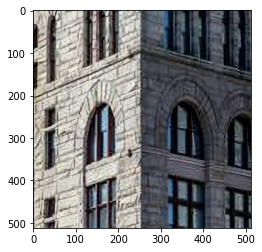

In [67]:
import matplotlib.pyplot as plt

a = tf.cast(tf.clip_by_value(enhanced_img[0], 0, 255), tf.uint8)
plt.imshow(a)
plt.show()

In [68]:
from PIL import Image

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

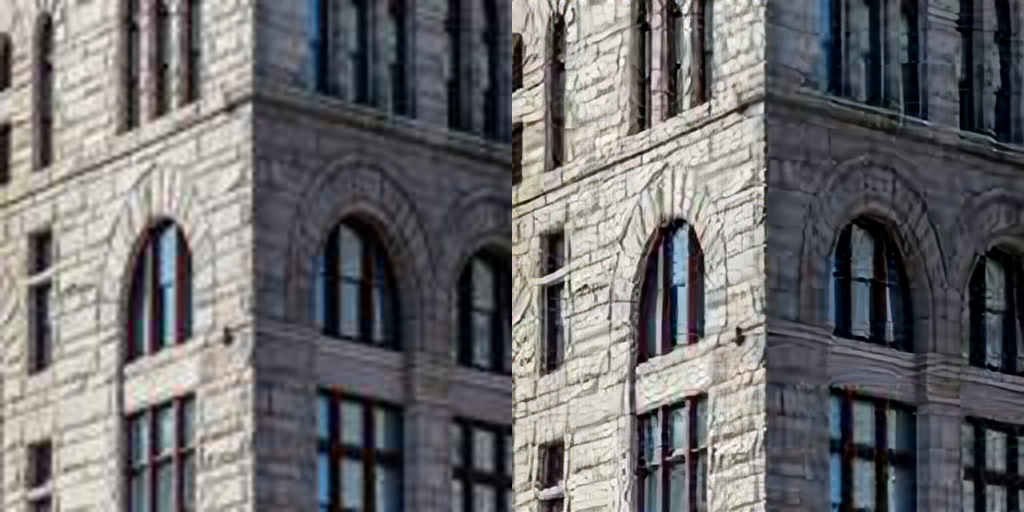

In [69]:
super_resolution_img = Image.fromarray(a.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((512, 512))

down_sampled_image = Image.open('/content/downsampled_image.jpg').resize((512, 512))

get_concat_h(down_sampled_image, super_resolution_img)

## Comparison with the original TF Hub model

In [ ]:
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")

In [44]:
low_resolution_image = load_img('/content/sample_images/gratisography-old-building-corner-1170x780.jpg')
super_resolution = model(low_resolution_image) 

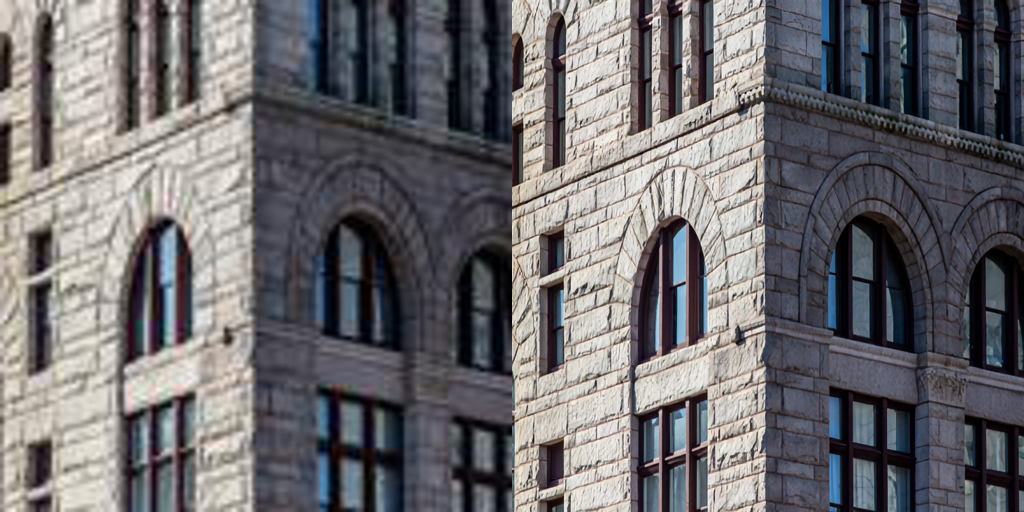

In [45]:
super_resolution_processed = tf.cast(tf.clip_by_value(super_resolution[0], 0, 255), tf.uint8)

super_resolution_img = Image.fromarray(super_resolution_processed.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((512, 512))

get_concat_h(down_sampled_image, super_resolution_img)

## Inference with the distilled version of the model (33 KB)

In [ ]:
!wget https://github.com/captain-pool/GSOC/releases/download/2.0.0/compressed_esrgan.tflite

In [47]:
!ls -lh compressed_esrgan.tflite

-rw-r--r-- 1 root root 33K Aug 26  2019 compressed_esrgan.tflite


In [58]:
# Utility for image loading and preprocessing
import numpy as np
import PIL

def load_img_dis(path_to_img, downsample=True, save_path="downsampled_image_dis.jpg"):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = img.numpy()
    img = PIL.Image.fromarray(img)
    if downsample:
        img = img.resize((320, 180), PIL.Image.BICUBIC) 
        # Shape referred from here: https://github.com/captain-pool/GSOC/tree/master/E3_Distill_ESRGAN
    if save_path:
        img.save(save_path)
    img = np.asarray(img)
    img = tf.cast(img, dtype=tf.float32)
    img = img[tf.newaxis, :]
    return img

In [59]:
low_res_image = load_img_dis('/content/sample_images/gratisography-old-building-corner-1170x780.jpg', True)
low_res_image.shape.as_list()

[1, 180, 320, 3]

In [62]:
# Load the image.
low_res_image = load_img('downsampled_image_dis.jpg', False, None)

# Load the model.
interpreter = tf.lite.Interpreter(model_path='compressed_esrgan.tflite')

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Invoke the interpreter to run inference.
interpreter.set_tensor(input_details[0]['index'], low_res_image)
interpreter.invoke()

# Retrieve the enhanced image.
enhanced_img = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

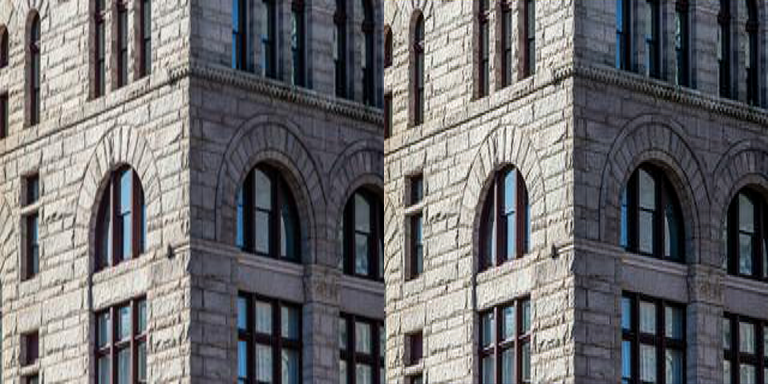

In [64]:
a = tf.cast(tf.clip_by_value(enhanced_img[0], 0, 255), tf.uint8)
super_resolution_img = Image.fromarray(a.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((384, 384))

down_sampled_image = Image.open('/content/downsampled_image_dis.jpg').resize((384, 384))

get_concat_h(down_sampled_image, super_resolution_img)